<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_07_Metaparameters_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

## Numerical Analysis
import numpy as np
import scipy.stats as stats

## Dataset Management
import pandas as pd

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## High-Quality Figures
from IPython import display
display.set_matplotlib_formats("svg")

# Predict Residual Sugar

In [ ]:
# We will use the Wine dataset and this time we want to predict residual sugar
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep = ";")

data = data[data["total sulfur dioxide"] < 200]

# Normalize all features
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,-0.786623
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,-0.786623
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,0.453492
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623


In [ ]:
# Convert the data into tensors
cols2zscore = cols2zscore.drop("residual sugar")
dataT = torch.tensor(data[cols2zscore].values).float()
sugar = torch.tensor(data["residual sugar"].values).float()

print(dataT.shape)
print(sugar.shape)

# We need the labels to be tensor
sugar = sugar[:,None]
print(sugar.shape)

torch.Size([1597, 11])
torch.Size([1597])
torch.Size([1597, 1])


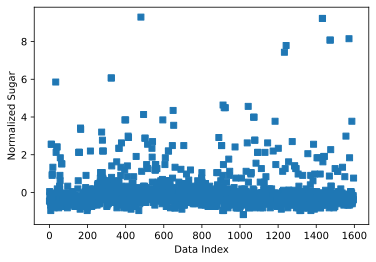

In [ ]:
# Plot the sugar data
plt.plot(sugar, "s")
plt.xlabel("Data Index")
plt.ylabel("Normalized Sugar")
plt.show()
# There are many outliers, but could be genuine as well

In [ ]:
# Split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, sugar, test_size=0.1)

# Convert to pytorch datasets
train_dataT = TensorDataset(train_data, train_labels)
test_dataT = TensorDataset(test_data, test_labels)

# Convert to dataloader
batchsize = 32
train_loader = DataLoader(train_dataT, batch_size=batchsize, shuffle = True, drop_last=True)
test_loader = DataLoader(test_dataT, batch_size=test_dataT.tensors[0].shape[0])

In [ ]:
# Define the model class
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        # Input layer
        self.input = nn.Linear(11,16)

        # Define two hidden layers
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        # Define the output layer
        self.output = nn.Linear(32,1)

    # Forwad Pass
    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.output(x)

In [ ]:
# Train the model
numepochs = 1000

def trainTheModel():
    # Loss function and optimizer
    lossfun = nn.MSELoss() # Regression, not classification problem
    optimizer = torch.optim.SGD(winenet.parameters(), lr = 0.01)

    # Initialize the losses
    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)

    # Loop over the epochs
    for epochi in range(numepochs):

        # switch on he training mode
        winenet.train()

        # Loop over the training data batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # Forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat,y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from single batch
            batchLoss.append(loss.item())
            
        # End of the batch loop
        # Average losses accross the baches
        trainLoss[epochi] = np.mean(batchLoss)

        # test the accuracy
        winenet.eval()
        # Extract X and y from dataloader
        X,y = next(iter(test_loader))
        # deactivate autograd
        with torch.no_grad():
            yHat = winenet(X)
        testLoss[epochi] = lossfun(yHat,y).item()
    # Final output
    return trainLoss, testLoss

In [ ]:
# Create the model and run it
winenet = ANNwine()
trainLoss, testLoss = trainTheModel()

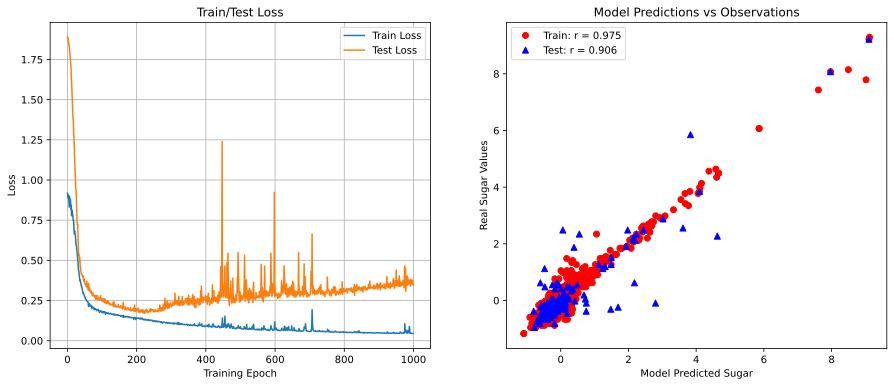

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(trainLoss, label = "Train Loss")
ax[0].plot(testLoss, label="Test Loss")
ax[0].set_title("Train/Test Loss")
ax[0].set_xlabel("Training Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid()

# Predictions vs real values
yHatTrain = winenet(train_data)
yHatTest = winenet(test_data)

ax[1].plot(yHatTrain.detach(), train_labels, "ro")
ax[1].plot(yHatTest.detach(), test_labels, "b^")
ax[1].set_xlabel("Model Predicted Sugar")
ax[1].set_ylabel("Real Sugar Values")
ax[1].set_title("Model Predictions vs Observations")

# Correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T, train_labels.T)[1,0]
corrTest = np.corrcoef(yHatTest.detach().T, test_labels.T)[1,0]
ax[1].legend(["Train: r = {:.3f}".format(corrTrain), "Test: r = {:.3f}".format(corrTest)])

plt.show()

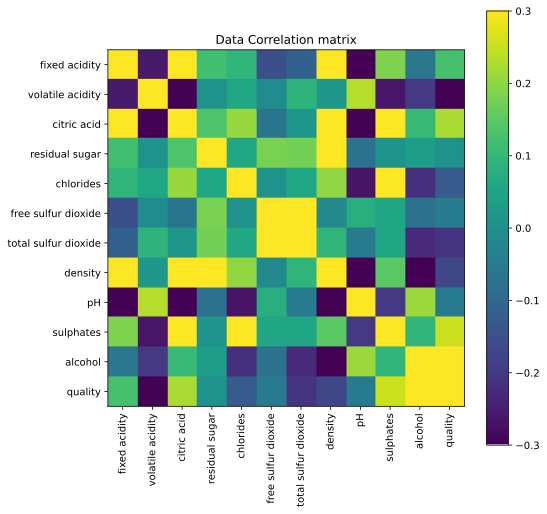

In [ ]:
# Correlation Matrix
fig = plt.figure(figsize=(8,8))

plt.imshow(np.corrcoef(data.T), vmin=-0.3, vmax=0.3)
plt.xticks(range(len(data.keys())), labels=data.keys(), rotation=90)
plt.yticks(range(len(data.keys())), labels=data.keys())
plt.colorbar()
plt.title("Data Correlation matrix")
plt.show()

# Loss Functions in PyTorch

## Mean-Square Erroe (MSE)

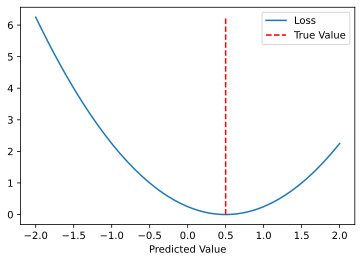

In [2]:
# Loss function instance
lossfunMSE = nn.MSELoss()

# Create predictions and real answer
yHat = torch.linspace(-2, 2, 101)
y = torch.tensor(0.5)

# Compute MSE Loss function
L = np.zeros(101)
for i,yy in enumerate(yHat):
    L[i] = lossfunMSE(yy,y)

plt.plot(yHat, L, label="Loss")
plt.plot([y,y], [0,np.max(L)], "r--",label="True Value")
plt.xlabel("Predicted Value")
plt.legend()
plt.show()
# The further we are from the true value, the larger the loss

## Binary Cross Entropy (BCE)

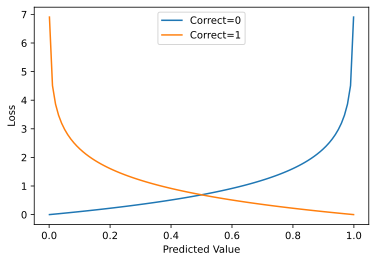

In [3]:
# Create loss function instance
lossfunBCE = nn.BCELoss()

# Create predictions and the real values
# In this case we create probabilities, thus values will be between 0 and 1
yHat = torch.linspace(.001, .999, 101)
y1 = torch.tensor(0.)
y2 = torch.tensor(1.)

# Compute the BCE Loss function
L = np.zeros((101,2))
for i,yy in enumerate(yHat):
    L[i,0] = lossfunBCE(yy,y1) # Correct answer is zero
    L[i,1] = lossfunBCE(yy,y2) # Correct Answer is 1

plt.plot(yHat, L)
plt.xlabel("Predicted Value")
plt.ylabel("Loss")
plt.legend(["Correct=0", "Correct=1"])
plt.show()

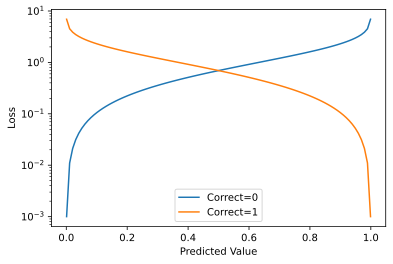

In [4]:
# Do the same in logarithmic form
plt.plot(yHat, L)
plt.xlabel("Predicted Value")
plt.ylabel("Loss")
plt.legend(["Correct=0", "Correct=1"])
plt.yscale("log")
plt.show()

In [5]:
# If we try BCE for values other than 0-1 range we get an error unless we apply sigmoid function
yHat = torch.tensor(2.)
#print(lossfunBCE(yHat, y2))

# First convert to probability using the sigmoid function
sig = nn.Sigmoid()
print(lossfunBCE(sig(yHat),y2))

tensor(0.1269)


In [6]:
# PyTorch recommends using a function that does the work of both sigmoid and BCE at once, called BCEWithLogitsLoss()
# Using the same prblem as above
lossfunBCE = nn.BCEWithLogitsLoss()
yHat = torch.tensor(2.)
print(lossfunBCE(yHat,y2))

tensor(0.1269)


## Categorical Cross-Entropy

In [7]:
# Loss function instance
lossfunCCE = nn.CrossEntropyLoss()

# Vector of output Layers (pre-softmax)
yHat = torch.tensor([[1., 4, 3]])

for i in range(3):
    correctAnswer = torch.tensor([i])
    thisloss = lossfunCCE(yHat, correctAnswer).item()
    print("Loss when correct answer is {}: {:.3f}".format(i,thisloss))

Loss when correct answer is 0: 3.349
Loss when correct answer is 1: 0.349
Loss when correct answer is 2: 1.349


In [8]:
# Loss function instance
lossfunCCE = nn.CrossEntropyLoss()

# Vector of output Layers (pre-softmax): Make 4 7 to see how much error drops
yHat = torch.tensor([[1., 7, 3]])

for i in range(3):
    correctAnswer = torch.tensor([i])
    thisloss = lossfunCCE(yHat, correctAnswer).item()
    print("Loss when correct answer is {}: {:.3f}".format(i,thisloss))

Loss when correct answer is 0: 6.021
Loss when correct answer is 1: 0.021
Loss when correct answer is 2: 4.021


In [9]:
# Repeat the same, using softmax before
# Since softmax is included in CCE, this is wrong because we use softmax twice
sm = nn.Softmax(dim=1)
yHat = torch.tensor([[1., 4, 3]])
yHat_sm = sm(yHat)

for i in range(3):
    correctAnswer = torch.tensor([i])
    thisloss = lossfunCCE(yHat_sm, correctAnswer).item()
    print("Loss when correct answer is {}: {:.3f}".format(i,thisloss))

Loss when correct answer is 0: 1.437
Loss when correct answer is 1: 0.766
Loss when correct answer is 2: 1.212


In [10]:
# Compare raw, softmax and log-softmax model outputs
sm = nn.LogSoftmax(dim=1)
yHat_logsm = sm(yHat)

print(yHat)
print()
print(yHat_sm)
print()
print(yHat_logsm)

tensor([[1., 4., 3.]])

tensor([[0.0351, 0.7054, 0.2595]])

tensor([[-3.3490, -0.3490, -1.3490]])


## Custom-Made Loss Function

In [11]:
class MyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x,y):
        loss = torch.abs(x-y)
        return loss

lfun = MyLoss()
lfun(torch.tensor(4), torch.tensor(5.2))

tensor(1.2000)

# MultiCalss ANN

## Generate the Data

In [12]:
# We will create a 3-class dataset
# 300 data points per cluster
nPerClust = 300
blur = 1

A = [1,1]
B = [5,1]
C = [4,4]

# Generate the datapoints (2D data)
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]
c = [C[0] + np.random.randn(nPerClust)*blur, C[1] + np.random.randn(nPerClust)*blur]

# Concatenate the data into a single matrix
data_np = np.hstack((a,b,c)).T #(900x2 matrix)

# Define the labels
true_labels = np.hstack((np.zeros(nPerClust),
                         np.ones(nPerClust),
                         1+np.ones(nPerClust))) # 900x1 vector

# Convert them to tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(true_labels).long()

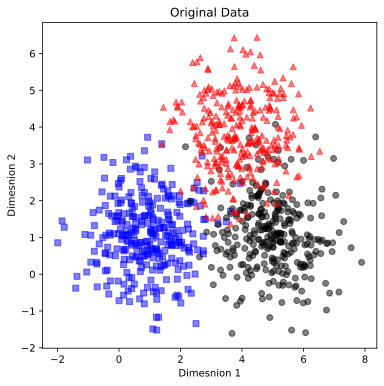

In [13]:
# Plot everything
fig = plt.figure(figsize=(6,6))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], "bs", alpha=0.5)
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], "ko", alpha=0.5)
plt.plot(data[np.where(labels==2)[0],0], data[np.where(labels==2)[0],1], "r^", alpha=0.5)
plt.title("Original Data")
plt.xlabel("Dimesnion 1")
plt.ylabel("Dimesnion 2")
plt.show()

In [14]:
# Split the data into train and test set
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1)

# Convert into PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Convert into data loaders
batchsize=16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [15]:
# Find the number of batches
print("There are {} batches, each with size {}".format(len(train_loader), batchsize))

There are 50 batches, each with size 16


## Create The Model

In [16]:
# create a class for the model
def createTheQwertyNet():

    class QwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input Layer
            self.input = nn.Linear(2,8)

            # Hidden Layer
            self.fc1 = nn.Linear(8,8)

            # Output Layer
            self.output = nn.Linear(8,3)

        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)

    # Create model instance
    net = QwertyNet()

    # loss function
    loss = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)

    return net, loss, optimizer

In [17]:
net, loss, opt = createTheQwertyNet()
print(net)

QwertyNet(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


In [18]:
# Input 10 samples just to test the model
input = torch.rand(10,2)
print(input)

tensor([[0.6626, 0.3178],
        [0.8627, 0.6497],
        [0.9732, 0.8703],
        [0.1672, 0.1932],
        [0.6974, 0.4979],
        [0.9385, 0.7591],
        [0.6600, 0.1222],
        [0.4205, 0.3290],
        [0.9644, 0.2375],
        [0.0082, 0.6656]])


In [19]:
net(input)

tensor([[-0.2812, -0.0409,  0.0448],
        [-0.2891, -0.0505,  0.0385],
        [-0.2968, -0.0513,  0.0358],
        [-0.2912, -0.0435,  0.0713],
        [-0.2877, -0.0487,  0.0433],
        [-0.2928, -0.0510,  0.0365],
        [-0.2787, -0.0387,  0.0477],
        [-0.2888, -0.0449,  0.0496],
        [-0.2723, -0.0316,  0.0436],
        [-0.3040, -0.0444,  0.0823]], grad_fn=<AddmmBackward0>)

In [20]:
# Define a function to train the model
def function2TrainTheModel():

    # define the number of epochs
    numepochs = 1000

    # create a new model
    net, lossfun, optimizer = createTheQwertyNet()

    # Initialize the losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Start training
        net.train()

        # Loop over the batches
        batchAcc = []
        batchLoss =[]

        for X,y in train_loader:

            # Forward Pass and Loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from each batch in the loop
            batchLoss.append(loss.item())

            # Compute acuracy (This time broken into multiple steps)
            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)
        # End of the loop

        # Batches average training accuracy per epoch
        trainAcc.append(np.mean(batchAcc))

        # Batches Average Loss
        losses[epochi] = np.mean(batchLoss)

        # Test The Accuracy
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        
        # Test Accuracy
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())

    # Return the output
    return trainAcc, testAcc, losses, net

In [21]:
# Now train the model
trainAcc, testAcc, losses, net = function2TrainTheModel()

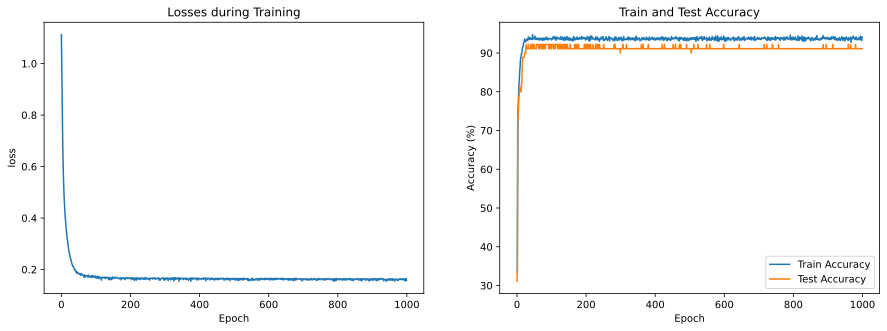

In [22]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses)
ax[0].set_ylabel("loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Losses during Training")

ax[1].plot(trainAcc, label="Train Accuracy")
ax[1].plot(testAcc, label="Test Accuracy")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Train and Test Accuracy")
ax[1].legend()

plt.show()

In [23]:
# Now that the model is trained, run the data through it to get category prediction
yHat = net(data)
predictions = torch.argmax(yHat,axis=1)

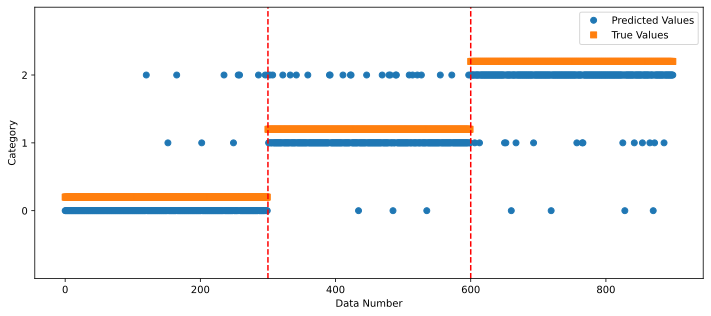

In [24]:
# Plot the category predictions
fig =plt.figure(figsize=(12,5))

plt.plot(predictions, "o", label="Predicted Values")
plt.plot(labels+0.2,"s", label="True Values")
plt.plot([300,300],[-1,3], "r--")
plt.plot([600,600],[-1,3], "r--")
plt.xlabel("Data Number")
plt.ylabel("Category")
plt.yticks([0,1,2])
plt.ylim([-1,3])
plt.legend()
plt.show()

In [35]:
accuracy = (predictions == labels).float()
print(accuracy[:50])
print(torch.mean(accuracy))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(0.9367)


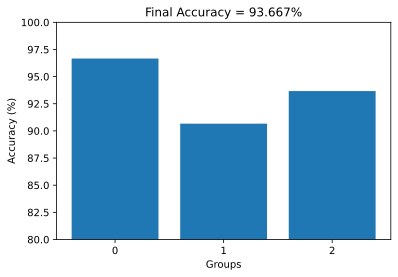

In [36]:
totalAcc = torch.mean(100*accuracy).item()

# Avrage by group
accuracyByGroup = np.zeros(3)
for i in range(3):
    accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])

# Visualize accuracy by groups
plt.bar(range(3), accuracyByGroup)
# Zoom in to see the differences
plt.ylim([80,100])
plt.xticks([0,1,2])
plt.xlabel("Groups")
plt.ylabel("Accuracy (%)")
plt.title("Final Accuracy = {:.3f}%".format(totalAcc))
plt.show()

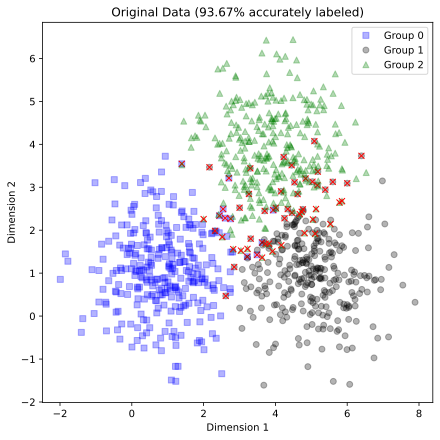

In [37]:
# Show the data in their original space labeled by accuracy
# data markers
colorShapes = [ 'bs','ko','g^' ]

# show the data
fig = plt.figure(figsize=(7,7))

# plot correct and incorrect labeled data
for i in range(3):
  # plot all data points for this label
  plt.plot(data[labels==i,0],data[labels==i,1],colorShapes[i],
                 alpha=.3,label=f'Group {i}')
  
  # cross out the incorrect ones
  idxErr = (accuracy==0) & (labels==i)
  plt.plot(data[idxErr,0],data[idxErr,1],'rx')

plt.title("Original Data ({:.2f}% accurately labeled)".format(totalAcc))
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

# SGD with Momentum

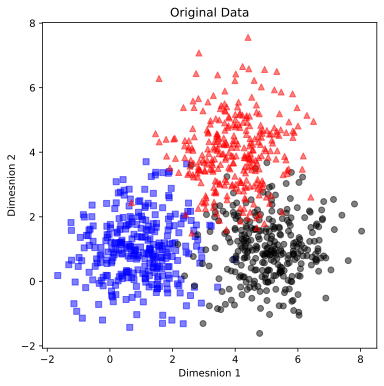

In [ ]:
# We will use the same dataset
# 300 data points per cluster
nPerClust = 300
blur = 1

A = [1,1]
B = [5,1]
C = [4,4]

# Generate the datapoints (2D data)
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]
c = [C[0] + np.random.randn(nPerClust)*blur, C[1] + np.random.randn(nPerClust)*blur]

# Concatenate the data into a single matrix
data_np = np.hstack((a,b,c)).T #(900x2 matrix)

# Define the labels
true_labels = np.hstack((np.zeros(nPerClust),
                         np.ones(nPerClust),
                         1+np.ones(nPerClust))) # 900x1 vector

# Convert them to tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(true_labels).long()

# Plot everything
fig = plt.figure(figsize=(6,6))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], "bs", alpha=0.5)
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], "ko", alpha=0.5)
plt.plot(data[np.where(labels==2)[0],0], data[np.where(labels==2)[0],1], "r^", alpha=0.5)
plt.title("Original Data")
plt.xlabel("Dimesnion 1")
plt.ylabel("Dimesnion 2")
plt.show()

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1)

# Convert to PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into data loader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [ ]:
# Define the model
def createQwertyNet(momentum):
    class QwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(2,8)

            # Hidden Layer
            self.fc1 = nn.Linear(8,8)

            # Output lAYER
            self.output = nn.Linear(8,3)
        
        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)
        
    # Create the model Instance
    net = QwertyNet()

    # define the loss function
    lossfun = nn.CrossEntropyLoss()

    # define optimizor
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=momentum)

    return net, lossfun, optimizer

In [ ]:
# Confirm momentum
optim = createQwertyNet(0.9)[2]
optim

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [ ]:
# Time to train
numepochs = 100

def function2TrainTheModel(momentum):

    # Create new model
    net, lossfun, optimizer = createQwertyNet(momentum)

    # Initialize the losses
    losses = []
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Switch training mode
        net.train()

        # Loop over training batches
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:

            # Forward Pass
            yHat = net(X)
            loss = lossfun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this particular batch
            batchLoss.append(loss.item())

            # Compute batch accuracy
            matches = (torch.argmax(yHat,axis=1) == y).float()
            accuracyPct = 100*torch.mean(matches)
            batchAcc.append(accuracyPct)
        # Batch Loop is over
        # Train Accuracy per epoch
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # Test Accuracy
        # turn the testing mode on
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        # Calculate test accuracy for the epoch
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
    # End of epochs, return the final results
    return trainAcc, testAcc, losses

In [ ]:
# Single run, no momentum
trainAcc, testAcc, losses = function2TrainTheModel(0.0)

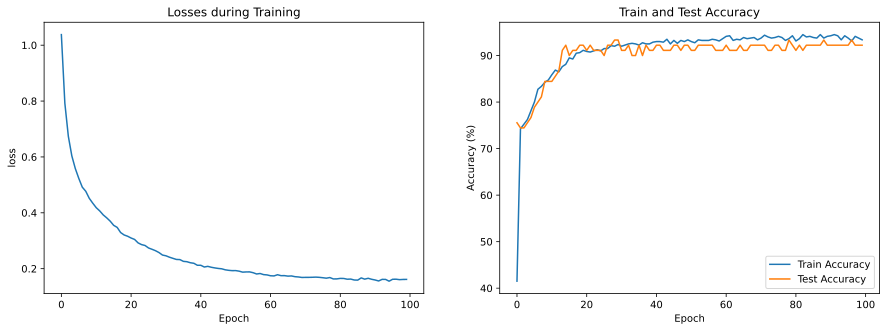

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses)
ax[0].set_ylabel("loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Losses during Training")

ax[1].plot(trainAcc, label="Train Accuracy")
ax[1].plot(testAcc, label="Test Accuracy")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Train and Test Accuracy")
ax[1].legend()

plt.show()

In [ ]:
# Now try different momenta
momenta = [0, 0.25, 0.5, 0.9, 0.95, 0.999]

# Initialize the results matrix
results = np.zeros((numepochs, len(momenta), 3))

for idx, mom in enumerate(momenta):
    trainAcc, testAcc, losses = function2TrainTheModel(mom)
    results[:,idx,0] = losses
    results[:,idx,1] = trainAcc
    results[:,idx,2] = testAcc

In [ ]:
results.shape

(100, 6, 3)

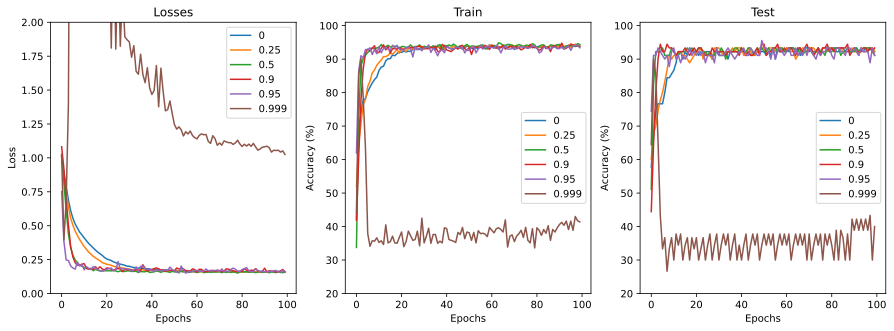

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

for i in range(3):
    ax[i].plot(results[:,:,i])
    ax[i].legend(momenta)
    ax[i].set_xlabel("Epochs")
    if i == 0:
        ax[i].set_ylabel("Loss")
        ax[i].set_ylim([0,2])
    else:
        ax[i].set_ylabel("Accuracy (%)")
        ax[i].set_ylim([20,101])

ax[0].set_title("Losses")
ax[1].set_title("Train")
ax[2].set_title("Test")

plt.show()